<a href="https://colab.research.google.com/github/VictorPelaez/demand_predictor/blob/master/tf_demand_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf

import pandas as pd
import numpy as np
import urllib
import json
import datetime

# Daily Demand dataset

In [0]:
# get data function and plot series

def get_daily_demand_data(start_date, end_date):
  """
    Description:
      Gets daily demand dataset from REE (spanish)
      link: https://www.ree.es/es/apidatos#request
    Input: 
      - start_date: format 'Y-m-d' as '2019-06-01'
      - end_date: 
    Output:
      - values:
      - times:
  """

  link = 'https://apidatos.ree.es/en/datos/demanda/evolucion?start_date='+start_date+'T00:00&end_date='+end_date+'T22:00&time_trunc=day'
  with urllib.request.urlopen(link) as url:
    s_raw = url.read()
    s = json.loads(s_raw)
    # print(s)
    values_dict = s['included'][0]['attributes']['values']
    values = [item['value'] for item in values_dict]
    times = [item['datetime'].split('T')[0] for item in values_dict]
    times = [datetime.datetime.strptime(t,"%Y-%m-%d").date() for t in times]
    return  np.array(values, dtype="float32"), np.array(times)

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

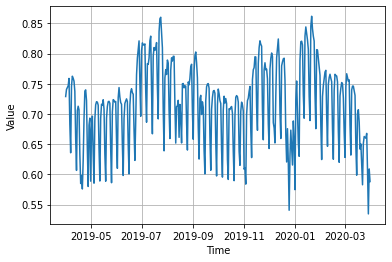

In [11]:
start_date = '2019-04-01'
end_date = '2020-03-31' 

NORM_VALUE = 1e6 # divided all values normalization

values, times = get_daily_demand_data(start_date, end_date)
values = values / NORM_VALUE

plot_series(times, values)

(300,) (66,)


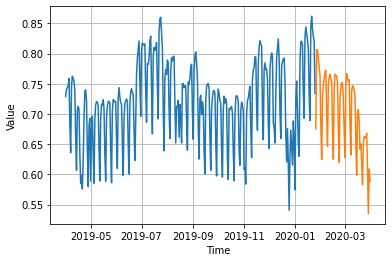

In [12]:
# split time series dataset

split_time = 300

time_train = times[:split_time]
x_train = values[:split_time]
time_valid = times[split_time:]
x_valid = values[split_time:]

plot_series(time_train, x_train)
plot_series(time_valid, x_valid)

print(x_train.shape, x_valid.shape)


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """
    Description:  
    Input: 
      - series:
      - window_size:
      - batch_size: the batches to use when training
      -shuffle_buffer: size buffer, how data will be shuffled

    Output:

  """
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1])) # x and y (last one)
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

window_size = 30
batch_size = 16
shuffle_buffer_size = 100

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 502/3000
17/17 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0227
Epoch 503/3000
17/17 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0228
Epoch 504/3000
17/17 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0228
Epoch 505/3000
17/17 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0227
Epoch 506/3000
17/17 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0227
Epoch 507/3000
17/17 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0226
Epoch 508/3000
17/17 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0228
Epoch 509/3000
17/17 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0227
Epoch 510/3000
17/17 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0228
Epoch 511/3000
17/17 [==============================] - 0s 3ms/ste

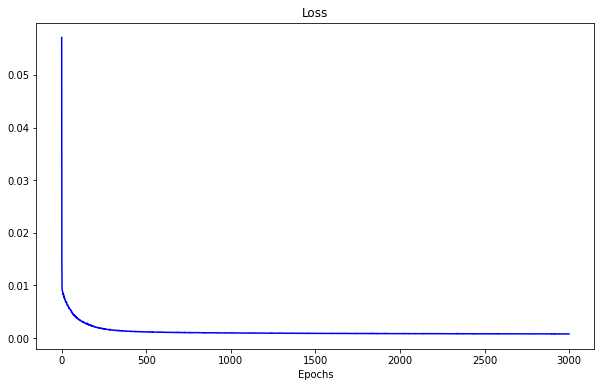

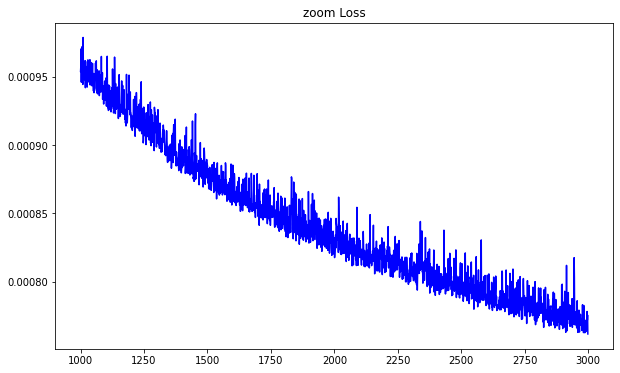

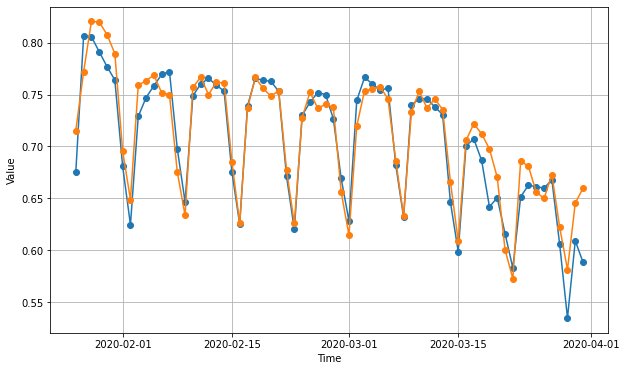

In [18]:
# Dense NN

l0 = tf.keras.layers.Dense(2*window_size+1, input_shape=[window_size], activation='relu')
l2 = tf.keras.layers.Dense(1)
model = tf.keras.models.Sequential([l0, l2])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3)

optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)

model.compile(loss="mse", optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs=3000, verbose=0)

loss=history.history['loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot Loss
#------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b')
plt.title('Loss')
plt.xlabel("Epochs")

n_epochs = 1000
plt.figure(figsize=(10, 6))
plt.plot(epochs[n_epochs:], loss[n_epochs:], 'b')
plt.title('zoom Loss')

forecast = []

for time in range(len(values) - window_size):
  forecast.append(model.predict(values[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, format='-o')
plot_series(time_valid, results, format='-o')

print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

0.0133481845


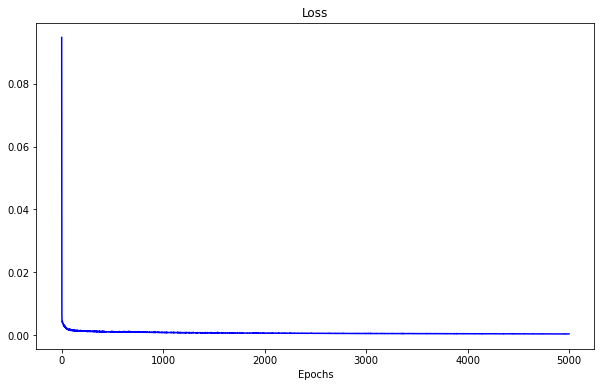

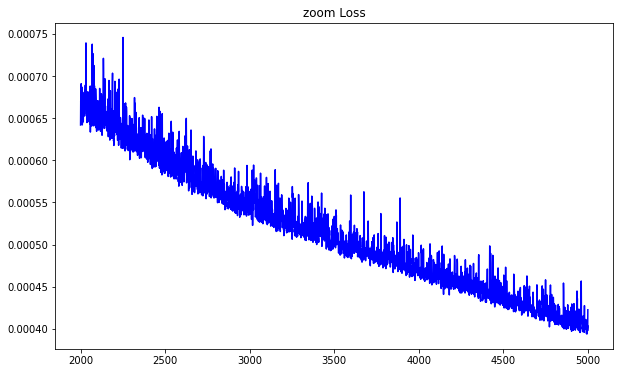

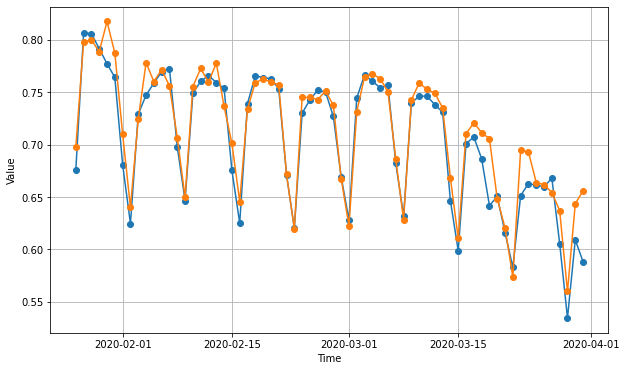

In [27]:
l0 = tf.keras.layers.Dense(2*window_size+1, activation="relu")
l1 = tf.keras.layers.Dense(1)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                                    # tf.keras.layers.LSTM(units=60, return_sequences=True),
                                    # tf.keras.layers.LSTM(units=60, return_sequences=True),
                                    tf.keras.layers.SimpleRNN(60, return_sequences=True),
                                    tf.keras.layers.SimpleRNN(60),
                                    l0,
                                    l1])

optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs=5000, verbose=0)

#------------------------------------------------
# Plot Loss
#------------------------------------------------
loss=history.history['loss']
epochs=range(len(loss)) # Get number of epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b')
plt.title('Loss')
plt.xlabel("Epochs")

n_epochs = 2000
plt.figure(figsize=(10, 6))
plt.plot(epochs[n_epochs:], loss[n_epochs:], 'b')
plt.title('zoom Loss')

forecast = []

for time in range(len(values) - window_size):
  forecast.append(model.predict(values[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, format='-o')
plot_series(time_valid, results, format='-o')

print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

In [1]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-3, 0, 0, 0.03])

NameError: ignored

# Intro to time series

In [0]:
len(times)

305

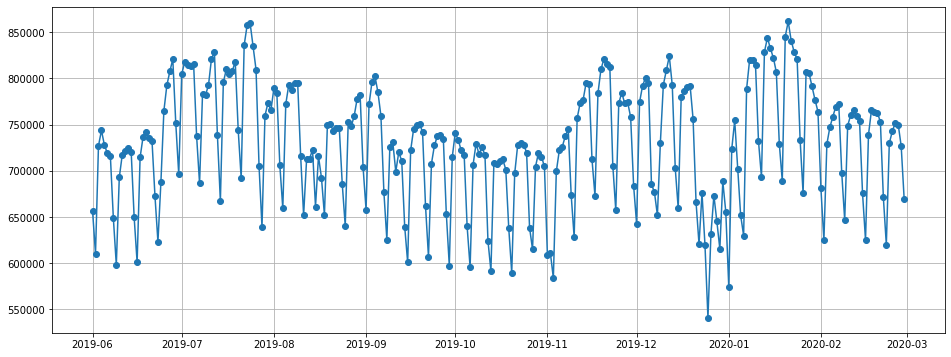

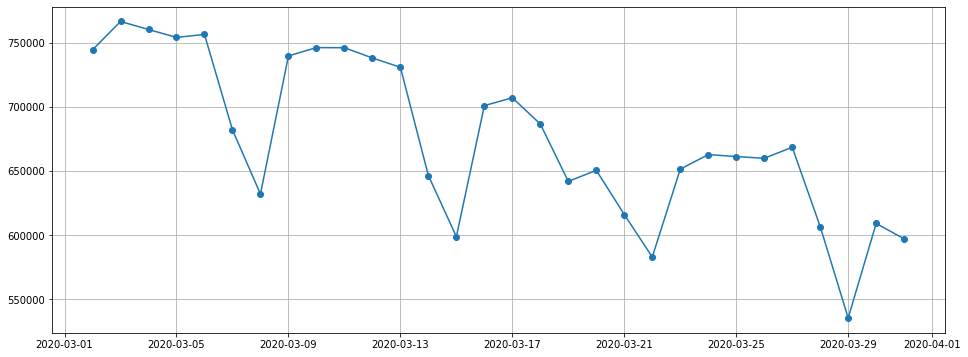

In [0]:
split_time = 30
N = len(times)
time_train = times[0:N-split_time-1]
x_train = values[0:N-split_time-1]
time_valid = times[N-split_time:]
x_valid = values[N-split_time:]

plot_series(time_train, x_train)
plot_series(time_valid, x_valid)

2223610611.764214
33912.098741379305


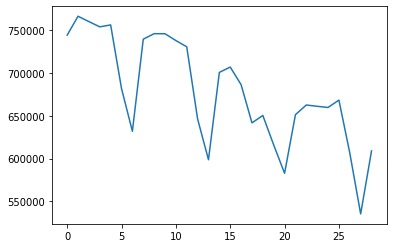

In [0]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)


moving_avg = moving_average_forecast(np.array(x_valid), 1)

plt.plot(moving_avg)

print(tf.keras.metrics.mean_squared_error(x_valid[1:], moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid[1:], moving_avg).numpy())

In [0]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)


moving_avg = moving_average_forecast(x_valid, 1)



AttributeError: ignored

# week 2 time series 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

ERROR! Session/line number was not unique in database. History logging moved to new session 59
2.2.0-rc2


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[-0.03245361],
       [ 0.00360638],
       [ 0.09090212],
       [-0.10440585],
       [-0.00596588],
       [ 0.05274386],
       [ 0.02879064],
       [-0.04005929],
       [ 0.07187669],
       [-0.03861348],
       [-0.03362968],
       [ 0.01983652],
       [-0.06613617],
       [ 0.05574497],
       [ 0.02979742],
       [ 0.11175361],
       [-0.01610481],
       [ 0.13452896],
       [ 0.32719052],
       [ 0.42141154]], dtype=float32), array([0.01584863], dtype=float32)]


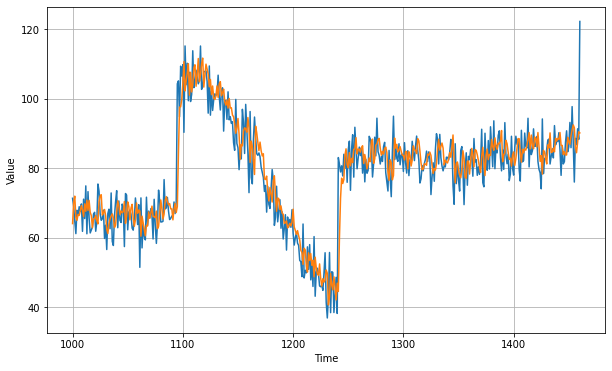

In [5]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [6]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.1365113

# Recurent NNs

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 35ms/step - loss: 195.7154 - mae: 196.0726 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 34ms/step - loss: 195.0723 - mae: 195.2820 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 36ms/step - loss: 193.3685 - mae: 194.0110 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 36ms/step - loss: 191.7916 - mae: 192.4081 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 37ms/step - loss: 190.2995 - mae: 190.5235 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 34ms/step - loss: 187.7608 - mae: 188.3583 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 33ms/step - loss: 185.1628 - mae: 185.8787 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 32ms/step - loss: 182.2499 - mae: 183.0484 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 35ms/step - loss: 179.4584 - mae: 

(1e-08, 0.0001, 0.0, 30.0)

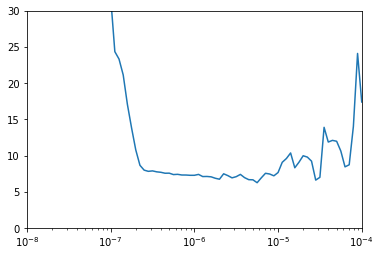

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 0s 35ms/step - loss: 79.5375 - mae: 82.2535
Epoch 2/400
8/8 [==============================] - 0s 35ms/step - loss: 21.7452 - mae: 22.4301
Epoch 3/400
8/8 [==============================] - 0s 33ms/step - loss: 15.7457 - mae: 16.4143
Epoch 4/400
8/8 [==============================] - 0s 32ms/step - loss: 12.2261 - mae: 12.7812
Epoch 5/400
8/8 [==============================] - 0s 33ms/step - loss: 10.3299 - mae: 10.6380
Epoch 6/400
8/8 [==============================] - 0s 33ms/step - loss: 16.6118 - mae: 17.1155
Epoch 7/400
8/8 [==============================] - 0s 35ms/step - loss: 13.0020 - mae: 13.6138
Epoch 8/400
8/8 [==============================] - 0s 36ms/step - loss: 9.4815 - mae: 10.0744
Epoch 9/400
8/8 [==============================] - 0s 35ms/step - loss: 8.1666 - mae: 8.6292
Epoch 10/400
8/8 [==============================] - 0s 34ms/step - loss: 8.0370 - mae: 8.5564
Epoch 11/400
8/8 [==============================] - 0s

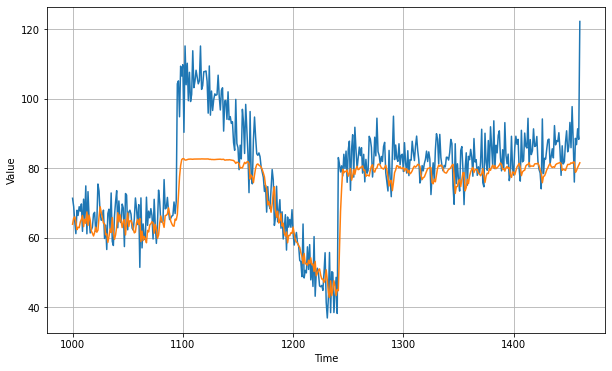

In [10]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [11]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

7.116614

<Figure size 432x288 with 0 Axes>

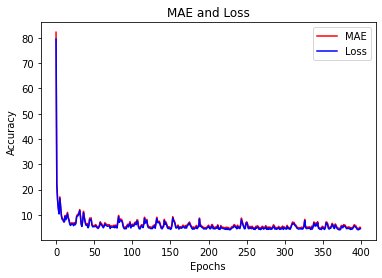

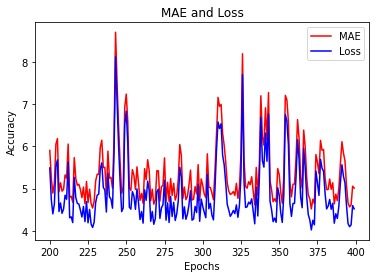

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

# week 4. CON1D+LSTM

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)